$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\renewcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\abs}[1]{\left\lvert#1\right\rvert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\Tr}[0]{^\top}
\newcommand{\grad}[0]{\nabla}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[0]{\middle\vert}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\trace}{trace}
\newcommand{\1}[1]{\mathbb{I}\left\{#1\right\}}
\newcommand{\setof}[1]{\left\{#1\right\}}
\newcommand{\DO}[1]{\mathrm{do}\left(#1\right)}
$$


# <center>Causal Inference 097400, Winter 2019-20<br><br>Homework 3</center>

#### <center>Aviv Rosenberg<br>`avivr@cs`</center>

##### <center>January 5, 2020<br></center>


The code implementing the assignment is in the `hw3` package right next to this notebook.

The structure of this project is:
```
+
|- data/                # Folder for raw data files
|- out/                 # Output folder where result CSVs are saved
|- hw3/
|---- data.py           # Data loading and preprocessing
|---- propensity.py     # Propensity score estimation
|- hw3.ipynb            # Notebook that runs the code and displays results
```

In [99]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd

DATA_FILE1 = 'data/data1.csv'
DATA_FILE2 = 'data/data2.csv'
OUT_DIR = 'out/'

os.makedirs(OUT_DIR, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

## Part 1: Loading the data

Here we're just loading the raw CSV files.

In [101]:
from hw3.data import load_data, encode_categorical, get_training_data
    
df1 = load_data(DATA_FILE1)
df2 = load_data(DATA_FILE2)

df1.tail(5)

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_51,x_52,x_53,x_54,x_55,x_56,x_57,x_58,T,Y
4797,21,C,0.0,0.0,67,140,0,0,2,0,...,0,0,0,0,0,1,47,39,0,-1.452833
4798,24,E,0.0,0.0,62,130,0,0,0,0,...,0,0,0,0,0,1,46,40,0,-10.182280
4799,33,C,5.0,15.0,63,137,0,0,0,0,...,0,0,0,0,0,0,46,38,0,0.441606
4800,36,C,10.0,22.0,60,110,0,0,1,0,...,0,0,0,0,0,0,46,38,0,-1.336014
4801,18,C,0.0,0.0,65,110,0,0,0,0,...,0,0,0,0,0,0,45,37,0,8.828653


 Some variables in the dataset (e.g. `x_2`) are given as categorical values, so we encode these as sequential integers.

In [102]:
df1 = encode_categorical(df1)
df2 = encode_categorical(df2)
dataframes = (df1, df2)

df1.tail(5)

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_51,x_52,x_53,x_54,x_55,x_56,x_57,x_58,T,Y
4797,21,2.0,0.0,0.0,67,140,0,0,2,0,...,0,0,0,0,0,1,47,39,0,-1.452833
4798,24,4.0,0.0,0.0,62,130,0,0,0,0,...,0,0,0,0,0,1,46,40,0,-10.182280
4799,33,2.0,5.0,15.0,63,137,0,0,0,0,...,0,0,0,0,0,0,46,38,0,0.441606
4800,36,2.0,10.0,22.0,60,110,0,0,1,0,...,0,0,0,0,0,0,46,38,0,-1.336014
4801,18,2.0,0.0,0.0,65,110,0,0,0,0,...,0,0,0,0,0,0,45,37,0,8.828653


Let's take a look at the outcome distribution among the treatment and control groups.

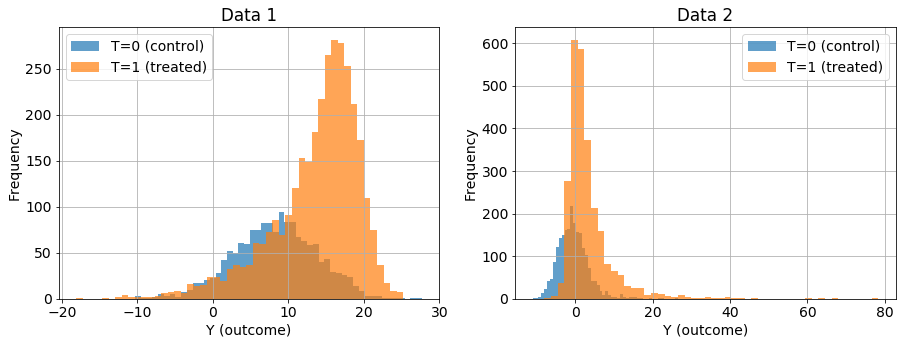

In [113]:
fig, ax = plt.subplots(nrows=1, ncols=len(dataframes), figsize=(15, 5))
for i, df in enumerate(dataframes):
    groups = df.groupby('T')
    groups['Y'].plot(kind='hist', ax=ax[i], sharex=True, alpha=0.7, bins=50)
    ax[i].set_title(f'Data {i+1}')
    ax[i].set_xlabel('Y (outcome)')
    ax[i].grid(True)
    ax[i].legend([f'T=0 (control)','T=1 (treated)'])

In both datasets we can see a better outcome on average for the treated, but of course this does not prove a causal effect.

# Part 2: Propensity Estimation

The *propensity score* is defined as $e(\vec{x}):=\Pr{\left(\rvar{T}=1\given \rvec{X}=\vec{x}\right)}$.
In other words, it is the probability that a treatment $\rvar{T}=1$ will be assigned to a
unit with covariates $\rvec{X}=\vec{x}$.

We would like to obtain an estimator for the propensity score, $\hat e(\vec{x})$, from the data.
One important aspect of this estimator is that we would like it to be *calibrated*.
Briefly, this means that for if for example we look at all units $\vec{x}$ such that $e(\vec{x})=0.8$, we expect 80\% of them to actually belong to the treatment group ($\rvar{T}=1$).
To estimate the propensities, we first fit a classification model to predict $\rvar{T}$ from $\rvec{X}$. We used the two most common models for propensity score estimation, logistic regression and gradient boosting machines.
Then, for each fitted model we applied a calibration method to obtain a new model with better-calibrated probability outputs. The calibration is performed on a disjoint validation set which includes 20\% of the data chosen at random but with stratification on $\rvar{T}$. The propensity scores from the model with the lowest Brier score are used.

The following plots show the calibration curves of the logistic regression (top row) and the GBM models (bottom row).
The ideal calibration is shown as a dotted line.
For each classifier, two calibration methods, Platt and Isotonic Regression, are shown.
In the legend, both the ROC-AUC score (`a`) and the Brier score (`b`) are reported as measures of the model's
classification performance (higher is better) and de-calibration level (lower is better), respectively.
We tried multiple hyper-parameter configurations for the different classifiers;
the results were qualitatively very similar, so here we only report one configuration.

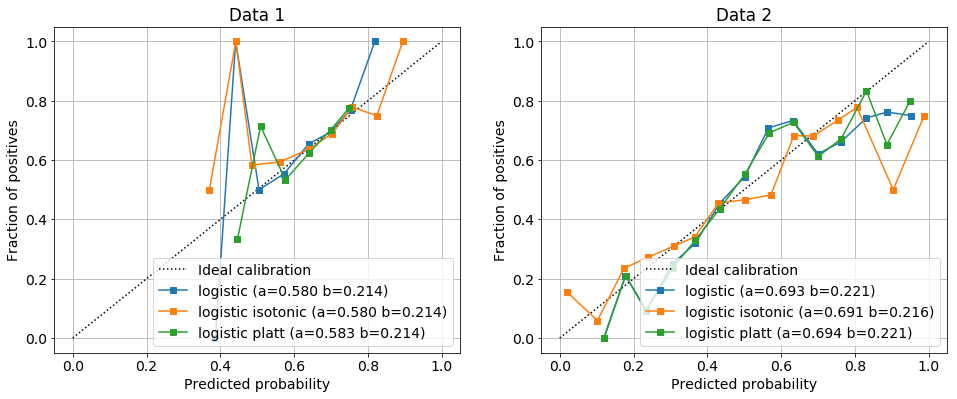

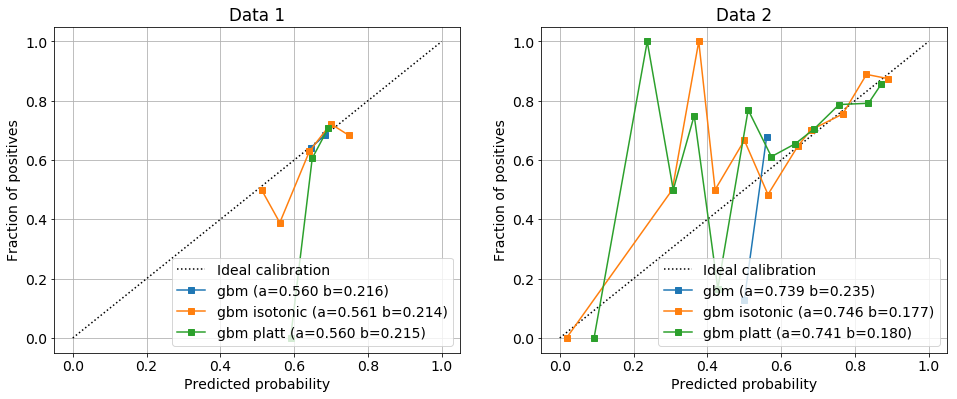

In [114]:
from hw3.propensity import estimate_propensity

methods = ('logistic', 'gbm')

# Create a dataframe to store propensities from each dataset and each method
midx = pd.MultiIndex.from_product([('data1', 'data2'), methods], names=['dataset', 'method'])
df_propensity = pd.DataFrame(columns=midx)

for method in methods:
    fig, ax = plt.subplots(nrows=1, ncols=len(dataframes), figsize=(16, 6))
    
    for i, df in enumerate(dataframes):
        # Get covariates X and treatment assignment t as numpy arrays
        # Scale covariates to zero-mean and unit-variance.
        X, _, t = get_training_data(df, scale_covariates=True)
        
        # Train a model to estimate propensity using current method,
        # calibrate with two approaches and generate a calibration plot
        prop = estimate_propensity(X, t, method=method, plot_args=dict(name=method, ax=ax[i]))
        df_propensity[(f'data{i+1}', method)] = prop
        
        ax[i].set_title(f'Data {i+1}')

This gives us all the propensity scores from both methods:

In [116]:
df_propensity.head(5)

dataset     data1               data2          
method   logistic       gbm  logistic       gbm
0        0.590792  0.652589  0.793711  0.586237
1        0.602383  0.678686  0.572192  0.557706
2        0.669682  0.678686  0.889299  0.586237
3        0.678313  0.678686  0.261778  0.494806
4        0.679773  0.678686  0.441294  0.561953

We now plot the distribution of propensity scores between treated and control groups, for each estimation method, to visualize the propensity estimation results from both methods.

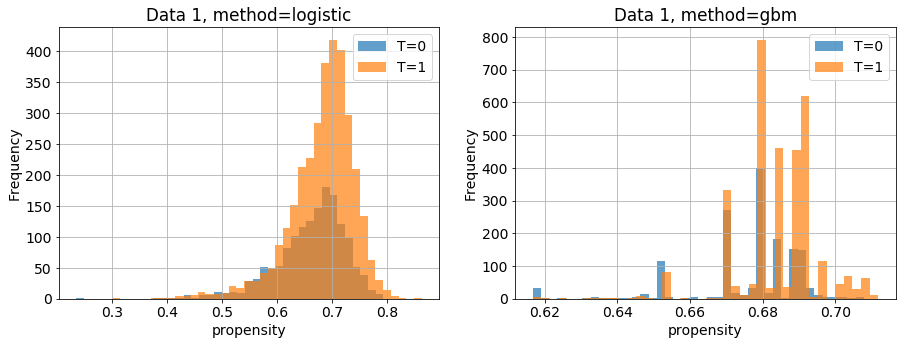

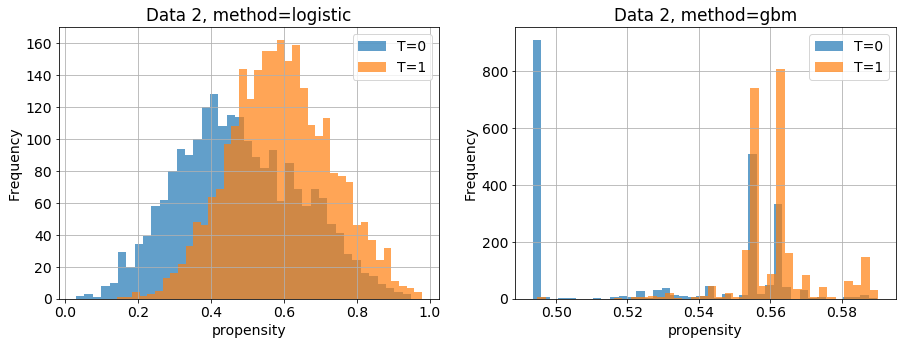

In [119]:
for i, df in enumerate((df1, df2)):
    fig, ax = plt.subplots(nrows=1, ncols=len(methods), figsize=(15, 5))
    df_tmp = df.copy()
    for j, method in enumerate(methods):
        df_tmp['propensity'] = df_propensity[(f'data{i+1}', method)]
        groups = df_tmp.groupby('T')
        groups['propensity'].plot(kind='hist', sharex=True, alpha=0.7, bins=40, ax=ax[j])
        ax[j].set_title(f'Data {i+1}, method={method}')
        ax[j].set_xlabel('propensity')
        ax[j].grid(True)
        ax[j].legend([f'T=0','T=1'])

Based on the results, we opted to use the Logistic Regression method for the propensity estimation.
On the first dataset, both methods performed similarly both in terms of Brier score and ROC-AUC.
However, on the second dataset the GBM method performed better under both metrics.
Even so, the GBM method produces sharp propensity distributions with values in a small range (~0.1).
These results may indicate strong overfitting, and are qualitatively less feasible as distributions obtained
from a real-world selection process.
In addition, the GBM-based approach leads to less common-support in terms of propensity score between the treatment and control groups. This will cause us to ignore more data in order to ensure that the overlap assumption holds.

In [122]:
# Save the LR propensity estimates into a new dataframe.
df_prop_lr = pd.DataFrame(dict(data1=df_propensity[('data1', 'logistic')], data2=df_propensity[('data2','logistic')]))

# Write the propensities to an output file with the requested format.
df_prop_lr.transpose().to_csv(f'{OUT_DIR}/models_propensity.csv', header=False)
df_prop_lr.transpose()

,0,1,2,3,4,5,6,7,8,9,...,4792,4793,4794,4795,4796,4797,4798,4799,4800,4801
data1,0.590792,0.602383,0.669682,0.678313,0.679773,0.648671,0.744384,0.689511,0.552556,0.687808,...,0.579295,0.628831,0.698783,0.645917,0.672514,0.647833,0.563145,0.722298,0.579669,0.597481
data2,0.793711,0.572192,0.889299,0.261778,0.441294,0.463318,0.203443,0.778153,0.524057,0.711043,...,0.529296,0.408576,0.330675,0.298402,0.613945,0.355396,0.567562,0.489897,0.655051,0.461800


## Part 3: IPW

The ATT, or average treatment effect on the treated is defined as
$$
ATT =  \E[]{Y^1-Y^0\given T=1},
$$
where $Y^t$ is the potential outcome of $T=t$ and we assume a binary treatment, i.e. $t\in\setof{0,1}$.
